In [1]:
import json
import cv2
import easyocr
import os


def convert_easyocr_to_json(image_path):
    """
    Convert OCR result to JSON format using EasyOCR and OpenCV.

    Args:
        image_path (str): Path to the input image.

    Returns:
        dict: JSON structure with OCR data.
    """
    # Load the image to get dimensions
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    image_height, image_width, _ = image.shape

    # Initialize EasyOCR reader
    reader = easyocr.Reader(["en"])  # Add languages as needed
    ocr_results = reader.readtext(image_path, detail=1)  # Perform OCR with bounding boxes

    # Construct JSON structure
    json_output = {
        "shapes": [],
        "flags": {},
        "imagePath": image_path,
        "imageData": None,
        "imageHeight": image_height,
        "imageWidth": image_width,
        "otherData": None
    }

    ocr_text = []

    for result in ocr_results:
        bounding_box, text, confidence = result
        
        # Convert bounding box points to float to ensure JSON serialization
        bounding_box = [[float(point[0]), float(point[1])] for point in bounding_box]
        
        x_min = bounding_box[0][0]
        y_min = bounding_box[0][1]
        x_max = bounding_box[2][0]
        y_max = bounding_box[2][1]

        # Prepare shape entry
        shape = {
            "label": "",  # Label can be adjusted dynamically based on text processing
            "points": [[x_min, y_min], [x_max, y_max]],
            "group_id": None,
            "description": "",
            "shape_type": "rectangle",
            "flags": {},
            "ocr_value": {
                "text": text,
                "extracted_texts": [
                    {
                        "text": text,
                        "confidence": confidence,
                        "bounding_box": bounding_box
                    }
                ]
            }
        }

        # Add shape to JSON
        json_output["shapes"].append(shape)

        # Collect OCR text for the .txt file
        ocr_text.append(text)

    return json_output, ocr_text


def save_ocr_results(image_path, json_result, ocr_text):
    """
    Save OCR results as a .json file and a .txt file.

    Args:
        image_path (str): Path to the input image.
        json_result (dict): OCR results in JSON format.
        ocr_text (list): OCR text extracted from the image.
    """
    # Extract the image name (without extension)
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    # Save the OCR results as a .json file
    json_file_path = f"{image_name}.json"
    with open(json_file_path, "w", encoding="utf-8") as f:
        json.dump(json_result, f, ensure_ascii=False, indent=4)

    # Save the OCR text as a .txt file
    txt_file_path = f"{image_name}.txt"
    with open(txt_file_path, "w", encoding="utf-8") as f:
        # Join all OCR text entries into a single string with line breaks
        f.write("\n".join(ocr_text))

    print(f"OCR results saved to {json_file_path} and {txt_file_path}.")


# Example Usage
if __name__ == "__main__":
    # Provide image path
    image_path = "/home/aurexus/Videos/easy_ocr/sample_images_pertus/1998_11_1_A15.jpg"

    try:
        # Convert OCR results
        json_result, ocr_text = convert_easyocr_to_json(image_path)

        # Save the results to .json and .txt files
        save_ocr_results(image_path, json_result, ocr_text)

    except Exception as e:
        print(f"Error: {e}")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


OCR results saved to 1998_11_1_A15.json and 1998_11_1_A15.txt.


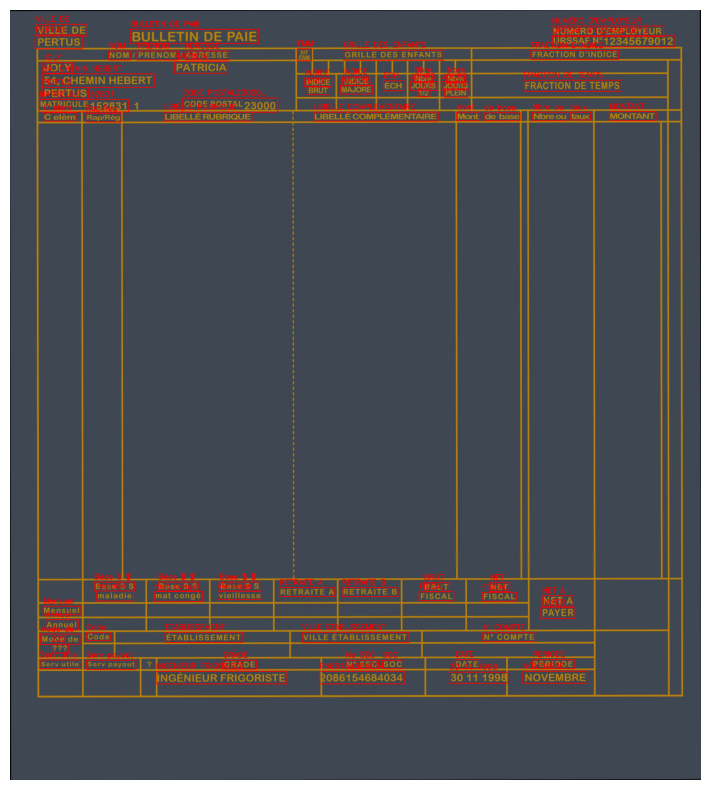

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json

def plot_bounding_boxes_with_text(image_path, ocr_results):
    """
    Plot bounding boxes on an image and show OCR text values.

    Args:
        image_path (str): Path to the input image.
        ocr_results (list): List of OCR results with bounding boxes and text.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Convert image from BGR to RGB (for displaying with matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the bounding boxes and OCR text
    for result in ocr_results:
        bounding_box, text, _ = result
        points = bounding_box
        # Convert points to integers
        points = [(int(point[0]), int(point[1])) for point in points]

        # Draw the bounding box (rectangle)
        cv2.polylines(image_rgb, [np.array(points)], isClosed=True, color=(255, 0, 0), thickness=2)

        # Get the top-left corner for text position
        x, y = points[0]

        # Display the OCR text near the bounding box
        cv2.putText(image_rgb, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the image with bounding boxes and text
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()


# Example Usage
if __name__ == "__main__":
    # Load OCR results from JSON file
    ocr_result_file = "/home/kanna/Django/dev/EasyOCR/1998_11_1_A15.json"
    with open(ocr_result_file, "r", encoding="utf-8") as f:
        json_data = json.load(f)
        # Extract OCR results from the loaded JSON (you need to extract the shapes)
        ocr_results = []
        for shape in json_data["shapes"]:
            bounding_box = shape["ocr_value"]["extracted_texts"][0]["bounding_box"]
            text = shape["ocr_value"]["text"]
            confidence = shape["ocr_value"]["extracted_texts"][0]["confidence"]
            ocr_results.append((bounding_box, text, confidence))

    image_path = "/home/kanna/Django/dev/EasyOCR/1998_11_1_A15.jpg"
    plot_bounding_boxes_with_text(image_path, ocr_results)


In [ ]:
import json
import re
import os
import csv

# French months list to improve month extraction
french_months = [
    "janvier",
    "février",
    "mars",
    "avril",
    "mai",
    "juin",
    "juillet",
    "août",
    "septembre",
    "octobre",
    "novembre",
    "décembre",
]


# Function to extract required data from OCR JSON
def extract_fields_from_json(json_data, image_path):
    """
    Extract the required fields (names, matricule, date, month) from the OCR results in the JSON format.
    
    Args:
        json_data (dict): OCR data loaded from JSON file.
        image_path (str): Path to the input image (used to extract year and month from filename).

    Returns:
        list: A list of extracted fields for CSV.
    """
    # Extract the year and month from the image filename
    filename = os.path.basename(image_path)
    # Assuming filename format: "1980_06_1_B01.jpg" -> year=1980, month=06
    filename_match = re.match(r"(\d{4})_(\d{2})", filename)
    filename_year, filename_month = None, None
    if filename_match:
        filename_year = filename_match.group(1)
        filename_month = filename_match.group(2)

    # Get OCR results from the JSON data
    results = json_data.get("shapes", [])
    text = " ".join([result['ocr_value']['text'] for result in results if 'ocr_value' in result])
    print("\nOCR Result:")
    print(text)  # Print the OCR result for verification

    # Preprocess text to remove unnecessary spaces or artifacts
    text = re.sub(
        r"\s+", " ", text.strip()
    )  # Replace multiple spaces with single space and strip trailing spaces

    # Regex patterns for fields
    name_pattern = r"D'INDICE\s+([A-ZÉÈÊÀÙÂÔÛÎÎÇ\-']+)\s+([A-ZÉÈÊÀÙÂÔÛÎÎÇ\-']+)"
    matricule_pattern = r"MATRICULE\s*(\d+)"
    date_pattern = (
        r"(\d{2})\s(\d{2})\s(\w{3,4})"  # Matches "DD MM YYYY" (with flexible year)
    )

    # Initialize placeholders for field-specific OCR data
    first_name_data = None
    last_name_data = None
    matricule_data = None
    date_data = None
    month_data = None

    # Extract first and last name
    name_match = re.search(name_pattern, text, re.IGNORECASE)
    if name_match:
        first_name_data = {
            "ocr_value": name_match.group(1).capitalize(),
            "confidence": max(
                [
                    result.get('ocr_value', {}).get('confidence', 0)
                    for result in results
                    if name_match.group(1).lower() in result.get('ocr_value', {}).get('text', '').lower()
                ],
                default=0,
            ),
            "bounding_box": next(
                (
                    result.get('ocr_value', {}).get('bounding_box')
                    for result in results
                    if name_match.group(1).lower() in result.get('ocr_value', {}).get('text', '').lower()
                ),
                None,
            ),
        }
        last_name_data = {
            "ocr_value": name_match.group(2).capitalize(),
            "confidence": max(
                [
                    result.get('ocr_value', {}).get('confidence', 0)
                    for result in results
                    if name_match.group(2).lower() in result.get('ocr_value', {}).get('text', '').lower()
                ],
                default=0,
            ),
            "bounding_box": next(
                (
                    result.get('ocr_value', {}).get('bounding_box')
                    for result in results
                    if name_match.group(2).lower() in result.get('ocr_value', {}).get('text', '').lower()
                ),
                None,
            ),
        }

    # Extract matricule
    matricule_match = re.search(matricule_pattern, text)
    if matricule_match:
        matricule_data = {
            "ocr_value": matricule_match.group(1),
            "confidence": max(
                [
                    result.get('ocr_value', {}).get('confidence', 0)
                    for result in results
                    if matricule_match.group(1) in result.get('ocr_value', {}).get('text', '')
                ],
                default=0,
            ),
            "bounding_box": next(
                (
                    result.get('ocr_value', {}).get('bounding_box')
                    for result in results
                    if matricule_match.group(1) in result.get('ocr_value', {}).get('text', '')
                ),
                None,
            ),
        }

    # Extract the month by searching known French months
    month = None
    for m in french_months:
        if m in text.lower():
            month_data = {
                "ocr_value": m.capitalize(),
                "confidence": max(
                    [result.get('ocr_value', {}).get('confidence', 0) for result in results if m in result.get('ocr_value', {}).get('text', '').lower()],
                    default=0,
                ),
                "bounding_box": next(
                    (result.get('ocr_value', {}).get('bounding_box') for result in results if m in result.get('ocr_value', {}).get('text', '').lower()), None
                ),
            }
            break

    # Extract date (day-month-year)
    date = None
    if month_data:
        date_match = re.search(
            date_pattern, text[: text.rfind(month_data["ocr_value"])], re.IGNORECASE
        )
        if date_match:
            day = date_match.group(1).zfill(2)  # Ensure two digits for day
            month_num = date_match.group(2).zfill(2)  # Ensure two digits for month
            year = date_match.group(3)

            # Post-processing: Replace common OCR errors in year (like 'q' instead of '0')
            year = re.sub(
                r"[^\d]", "0", year
            )  # Replace non-numeric characters with '0'

            # Cross-check year and month with the filename
            if filename_year and filename_month:
                if year != filename_year:
                    print(
                        f"Year mismatch: OCR found {year}, but filename has {filename_year}. Using {filename_year}."
                    )
                    year = filename_year
                if month_num != filename_month:
                    print(
                        f"Month mismatch: OCR found {month_num}, but filename has {filename_month}. Using {filename_month}."
                    )
                    month_num = filename_month

            date_data = {
                "ocr_value": f"{day}-{month_num}-{year}",  # Format as DD-MM-YYYY
                "confidence": max(
                    [
                        result.get('ocr_value', {}).get('confidence', 0)
                        for result in results
                        if f"{day}-{month_num}-{year}" in result.get('ocr_value', {}).get('text', '')
                    ],
                    default=0,
                ),
                "bounding_box": next(
                    (
                        result.get('ocr_value', {}).get('bounding_box')
                        for result in results
                        if f"{day}-{month_num}-{year}" in result.get('ocr_value', {}).get('text', '')
                    ),
                    None,
                ),
            }

    # Prepare row data for CSV
    csv_row = [
        filename,
        first_name_data["ocr_value"] if first_name_data else "",
        first_name_data["confidence"] if first_name_data else "",
        first_name_data["bounding_box"] if first_name_data else "",
        last_name_data["ocr_value"] if last_name_data else "",
        last_name_data["confidence"] if last_name_data else "",
        last_name_data["bounding_box"] if last_name_data else "",
        matricule_data["ocr_value"] if matricule_data else "",
        matricule_data["confidence"] if matricule_data else "",
        matricule_data["bounding_box"] if matricule_data else "",
        date_data["ocr_value"] if date_data else "",
        date_data["confidence"] if date_data else "",
        date_data["bounding_box"] if date_data else "",
        month_data["ocr_value"] if month_data else "",
        month_data["confidence"] if month_data else "",
        month_data["bounding_box"] if month_data else "",
    ]

    # Return the row data
    return csv_row


# Example usage with file paths
json_file_path = "/content/ocr_result.json"
# Load OCR data from the provided JSON file
with open(json_file_path, "r", encoding="utf-8") as json_file:
    json_data = json.load(json_file)
    image_paths = json_data.get("imagePath", [])
    print("ssss", image_paths)

# Open CSV file for writing
csv_filename = "ocr_extracted_data.csv"
with open(csv_filename, mode="w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow(
        [
            "image_name",
            "first_name_ocr_value",
            "first_name_confidence",
            "first_name_boundingbox",
            "last_name_ocr_value",
            "last_name_confidence",
            "last_name_bounding_box",
            "matricule_ocr_value",
            "matricule_confidence",
            "matricule_boundingbox",
            "date_ocr_value",
            "date_confidence",
            "date_boundingbox",
            "month_ocr_value",
            "month_confidence",
            "month_boundingbox",
        ]
    )

    # Process each image and write results to CSV
    for image_path in image_paths:
        csv_row = extract_fields_from_json(json_data, image_path)
        # Write the row to the CSV file
        csv_writer.writerow(csv_row)

print(f"CSV output written to {csv_filename}")


In [5]:
# import easyocr
import re
import os
import csv

# Initialize EasyOCR Reader
# reader = easyocr.Reader(["fr"])  # Assuming the text is in French

# French months list to improve month extraction
french_months = [
    "janvier",
    "février",
    "mars",
    "avril",
    "mai",
    "juin",
    "juillet",
    "août",
    "septembre",
    "octobre",
    "novembre",
    "décembre",
]


# Function to extract required data
def extract_fields(image_path):
    image_path = json_data.get("imagePath", [])
    print("IMAGE_PATH", image_path)
    # Extract the year and month from the image filename
    filename = os.path.basename(image_path)
    print("FILENAME", filename)
    # Assuming filename format: "1980_06_1_B01.jpg" -> year=1980, month=06
    filename_match = re.match(r"(\d{4})_(\d{2})", filename)
    filename_year, filename_month = None, None
    if filename_match:
        filename_year = filename_match.group(1)
        filename_month = filename_match.group(2)

    # Read text from image with bounding box and confidence
    # results = reader.readtext(        image_path, detail=1    )  # detail=1 provides bounding box and confidence
    # text = " ".join([result[1] for result in results])

    # Get OCR results from the JSON data
    results = json_data.get("shapes", [])
    text = " ".join([result['ocr_value']['text'] for result in results if 'ocr_value' in result])
    print("\nOCR Result:")
    print(text)  # Print the OCR result for verification

    # Preprocess text to remove unnecessary spaces or artifacts
    text = re.sub(
        r"\s+", " ", text.strip()
    )  # Replace multiple spaces with single space and strip trailing spaces

    # Regex patterns for fields
    name_pattern = r"D'INDICE\s+([A-ZÉÈÊÀÙÂÔÛÎÎÇ\-']+)\s+([A-ZÉÈÊÀÙÂÔÛÎÎÇ\-']+)"
    matricule_pattern = r"MATRICULE\s*(\d+)"
    # Updated date pattern to capture day, month, and year (allowing any non-numeric characters in the year)
    date_pattern = (
        r"(\d{2})\s(\d{2})\s(\w{3,4})"  # Matches "DD MM YYYY" (with flexible year)
    )

    # Initialize placeholders for field-specific OCR data
    first_name_data = None
    last_name_data = None
    matricule_data = None
    date_data = None
    month_data = None

    # Extract first and last name
    name_match = re.search(name_pattern, text, re.IGNORECASE)
    if name_match:
        first_name_data = {
            "ocr_value": name_match.group(1).capitalize(),
            "confidence": max(
                [
                    result[2]
                    for result in results
                    if name_match.group(1).lower() in result[1].lower()
                ],
                default=0,
            ),
            "bounding_box": next(
                (
                    result[0]
                    for result in results
                    if name_match.group(1).lower() in result[1].lower()
                ),
                None,
            ),
        }
        last_name_data = {
            "ocr_value": name_match.group(2).capitalize(),
            "confidence": max(
                [
                    result[2]
                    for result in results
                    if name_match.group(2).lower() in result[1].lower()
                ],
                default=0,
            ),
            "bounding_box": next(
                (
                    result[0]
                    for result in results
                    if name_match.group(2).lower() in result[1].lower()
                ),
                None,
            ),
        }

    # Extract matricule
    matricule_match = re.search(matricule_pattern, text)
    if matricule_match:
        matricule_data = {
            "ocr_value": matricule_match.group(1),
            "confidence": max(
                [
                    result[2]
                    for result in results
                    if matricule_match.group(1) in result[1]
                ],
                default=0,
            ),
            "bounding_box": next(
                (
                    result[0]
                    for result in results
                    if matricule_match.group(1) in result[1]
                ),
                None,
            ),
        }

    # Extract the month by searching known French months
    month = None
    for m in french_months:
        if m in text.lower():
            month_data = {
                "ocr_value": m.capitalize(),
                "confidence": max(
                    [result[2] for result in results if m in result[1].lower()],
                    default=0,
                ),
                "bounding_box": next(
                    (result[0] for result in results if m in result[1].lower()), None
                ),
            }
            break

    # Extract date (day-month-year)
    date = None
    if month_data:
        date_match = re.search(
            date_pattern, text[: text.rfind(month_data["ocr_value"])], re.IGNORECASE
        )
        if date_match:
            day = date_match.group(1).zfill(2)  # Ensure two digits for day
            month_num = date_match.group(2).zfill(2)  # Ensure two digits for month
            year = date_match.group(3)

            # Post-processing: Replace common OCR errors in year (like 'q' instead of '0')
            year = re.sub(
                r"[^\d]", "0", year
            )  # Replace non-numeric characters with '0'

            # Cross-check year and month with the filename
            if filename_year and filename_month:
                if year != filename_year:
                    print(
                        f"Year mismatch: OCR found {year}, but filename has {filename_year}. Using {filename_year}."
                    )
                    year = filename_year
                if month_num != filename_month:
                    print(
                        f"Month mismatch: OCR found {month_num}, but filename has {filename_month}. Using {filename_month}."
                    )
                    month_num = filename_month

            date_data = {
                "ocr_value": f"{day}-{month_num}-{year}",  # Format as DD-MM-YYYY
                "confidence": max(
                    [
                        result[2]
                        for result in results
                        if f"{day}-{month_num}-{year}" in result[1]
                    ],
                    default=0,
                ),
                "bounding_box": next(
                    (
                        result[0]
                        for result in results
                        if f"{day}-{month_num}-{year}" in result[1]
                    ),
                    None,
                ),
            }

    # Prepare row data for CSV
    csv_row = [
        filename,
        first_name_data["ocr_value"] if first_name_data else "",
        first_name_data["confidence"] if first_name_data else "",
        first_name_data["bounding_box"] if first_name_data else "",
        last_name_data["ocr_value"] if last_name_data else "",
        last_name_data["confidence"] if last_name_data else "",
        last_name_data["bounding_box"] if last_name_data else "",
        matricule_data["ocr_value"] if matricule_data else "",
        matricule_data["confidence"] if matricule_data else "",
        matricule_data["bounding_box"] if matricule_data else "",
        date_data["ocr_value"] if date_data else "",
        date_data["confidence"] if date_data else "",
        date_data["bounding_box"] if date_data else "",
        month_data["ocr_value"] if month_data else "",
        month_data["confidence"] if month_data else "",
        month_data["bounding_box"] if month_data else "",
    ]

    # Return the row data
    return csv_row


# Example usage with file paths
json_paths = ["/home/kanna/Django/dev/EasyOCR/1998_11_1_A15.json"]




# Open CSV file for writing
csv_filename = "ocr_extracted_data.csv"
with open(csv_filename, mode="w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow(
        [
            "image_name",
            "first_name_ocr_value",
            "first_name_confidence",
            "first_name_boundingbox",
            "last_name_ocr_value",
            "last_name_confidence",
            "last_name_bounding_box",
            "matricule_ocr_value",
            "matricule_confidence",
            "matricule_boundingbox",
            "date_ocr_value",
            "date_confidence",
            "date_boundingbox",
            "month_ocr_value",
            "month_confidence",
            "month_boundingbox",
        ]
    )

    # Process each image and write results to CSV
    for json_path in json_paths:

        # Load OCR data from the provided JSON file
        with open(json_path, "r", encoding="utf-8") as json_file:
            json_data = json.load(json_file)

        csv_row = extract_fields(json_data)
        # Write the row to the CSV file
        csv_writer.writerow(csv_row)

print(f"CSV output written to {csv_filename}")


IMAGE_PATH /home/aurexus/Videos/easy_ocr/sample_images_pertus/1998_11_1_A15.jpg
FILENAME 1998_11_1_A15.jpg

OCR Result:
VILLE DE NUMERO D'EMPLOYEUR PERTUS BULLETIN DE PAIE URSSAF N'12345679012 NOM PRENOM ADRESSE FMM GRILLE DES ENFANTS FRACTION D'INDICE JOLY PATRICIA 54, CHEMIN HEBERT INDICE INDICE Nbre Nbre BRUT MAJORE ECH JOURS JOURS FRACTION DE TEMPS PERTUS 1/2 PLEIN MATRICULE 152831 CODE POSTAL23000_ C elem RaplReg LIBELLE RUBRIQUE LIBELLE COMPLEMENTAIRE Mont de base Nbre ou taux MONTANT Base S $ Base $ $ Base $ $ BRUT NET maladie mat conge vieillesse RETRAITE A RETRAITE B FISCAL FISCAL NET A Mensuel PAYER Annuel Mode de Code ETABLISSEMENT VILLE ETABLISSEMENT N' COMPTE 222 Serv utile Serv payout GRADE No SEC SOC DATE PERIODE INGENIEUR FRIGORISTE Po86154684034 30 11 1998 NOVEMBRE


KeyError: 1

In [ ]:
import easyocr
import re
import os
import csv
import json

# Initialize EasyOCR Reader
reader = easyocr.Reader(["fr"])  # Assuming the text is in French

# French months list to improve month extraction
french_months = [
    "janvier",
    "février",
    "mars",
    "avril",
    "mai",
    "juin",
    "juillet",
    "août",
    "septembre",
    "octobre",
    "novembre",
    "décembre",
]

# Function to extract required data
def extract_fields(json_data, image_path):
    # Extract the year and month from the image filename
    filename = os.path.basename(image_path)
    print("FILENAME", filename)
    # Assuming filename format: "1980_06_1_B01.jpg" -> year=1980, month=06
    filename_match = re.match(r"(\d{4})_(\d{2})", filename)
    filename_year, filename_month = None, None
    if filename_match:
        filename_year = filename_match.group(1)
        filename_month = filename_match.group(2)

    # Read text from image with bounding box and confidence
    results = json_data.get("shapes", [])
    text = " ".join([result['ocr_value']['text'] for result in results if 'ocr_value' in result])
    print("\nOCR Result:")
    print(text)  # Print the OCR result for verification

    # Preprocess text to remove unnecessary spaces or artifacts
    text = re.sub(r"\s+", " ", text.strip())

    # Regex patterns for fields
    name_pattern = r"D'INDICE\s+([A-ZÉÈÊÀÙÂÔÛÎÎÇ\-']+)\s+([A-ZÉÈÊÀÙÂÔÛÎÎÇ\-']+)"
    matricule_pattern = r"MATRICULE\s*(\d+)"
    date_pattern = r"(\d{2})\s(\d{2})\s(\w{3,4})"

    # Initialize placeholders for field-specific OCR data
    first_name_data = None
    last_name_data = None
    matricule_data = None
    date_data = None
    month_data = None

    # Extract first and last name
    name_match = re.search(name_pattern, text, re.IGNORECASE)
    if name_match:
        first_name_data = {
            "ocr_value": name_match.group(1).capitalize(),
            "confidence": 0,
            "bounding_box": None
        }
        last_name_data = {
            "ocr_value": name_match.group(2).capitalize(),
            "confidence": 0,
            "bounding_box": None
        }

        # Loop over results to find matching bounding boxes and confidence
        for result in results:
            if len(result) >= 3:  # Ensure that result has at least 3 elements
                if first_name_data['ocr_value'].lower() in result[1].lower():
                    first_name_data['confidence'] = max(first_name_data['confidence'], result[2])
                    first_name_data['bounding_box'] = result[0]
                if last_name_data['ocr_value'].lower() in result[1].lower():
                    last_name_data['confidence'] = max(last_name_data['confidence'], result[2])
                    last_name_data['bounding_box'] = result[0]

    # Extract matricule
    matricule_match = re.search(matricule_pattern, text)
    if matricule_match:
        matricule_data = {
            "ocr_value": matricule_match.group(1),
            "confidence": 0,
            "bounding_box": None
        }
        for result in results:
            if len(result) >= 3:
                if matricule_match.group(1) in result[1]:
                    matricule_data['confidence'] = max(matricule_data['confidence'], result[2])
                    matricule_data['bounding_box'] = result[0]

    # Extract the month by searching known French months
    for m in french_months:
        if m in text.lower():
            month_data = {
                "ocr_value": m.capitalize(),
                "confidence": 0,
                "bounding_box": None
            }
            for result in results:
                if len(result) >= 3:
                    if m in result[1].lower():
                        month_data['confidence'] = max(month_data['confidence'], result[2])
                        month_data['bounding_box'] = result[0]
            break

    # Extract date (day-month-year)
    if month_data:
        date_match = re.search(date_pattern, text[: text.rfind(month_data["ocr_value"])], re.IGNORECASE)
        if date_match:
            day = date_match.group(1).zfill(2)  # Ensure two digits for day
            month_num = date_match.group(2).zfill(2)  # Ensure two digits for month
            year = date_match.group(3)

            # Post-processing: Replace common OCR errors in year (like 'q' instead of '0')
            year = re.sub(r"[^\d]", "0", year)

            # Cross-check year and month with the filename
            if filename_year and filename_month:
                if year != filename_year:
                    year = filename_year
                if month_num != filename_month:
                    month_num = filename_month

            date_data = {
                "ocr_value": f"{day}-{month_num}-{year}",
                "confidence": 0,
                "bounding_box": None
            }
            for result in results:
                if len(result) >= 3:
                    if f"{day}-{month_num}-{year}" in result[1]:
                        date_data['confidence'] = max(date_data['confidence'], result[2])
                        date_data['bounding_box'] = result[0]

    # Prepare row data for CSV
    csv_row = [
        filename,
        first_name_data["ocr_value"] if first_name_data else "",
        first_name_data["confidence"] if first_name_data else "",
        first_name_data["bounding_box"] if first_name_data else "",
        last_name_data["ocr_value"] if last_name_data else "",
        last_name_data["confidence"] if last_name_data else "",
        last_name_data["bounding_box"] if last_name_data else "",
        matricule_data["ocr_value"] if matricule_data else "",
        matricule_data["confidence"] if matricule_data else "",
        matricule_data["bounding_box"] if matricule_data else "",
        date_data["ocr_value"] if date_data else "",
        date_data["confidence"] if date_data else "",
        date_data["bounding_box"] if date_data else "",
        month_data["ocr_value"] if month_data else "",
        month_data["confidence"] if month_data else "",
        month_data["bounding_box"] if month_data else "",
    ]

    return csv_row


# Example usage with file paths
json_paths = ["/home/kanna/Django/dev/EasyOCR/1998_11_1_A15.json"]

# Open CSV file for writing
csv_filename = "ocr_extracted_data.csv"
with open(csv_filename, mode="w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow(
        [
            "image_name",
            "first_name_ocr_value",
            "first_name_confidence",
            "first_name_boundingbox",
            "last_name_ocr_value",
            "last_name_confidence",
            "last_name_bounding_box",
            "matricule_ocr_value",
            "matricule_confidence",
            "matricule_boundingbox",
            "date_ocr_value",
            "date_confidence",
            "date_boundingbox",
            "month_ocr_value",
            "month_confidence",
            "month_boundingbox",
        ]
    )

    # Process each image and write results to CSV
    for json_path in json_paths:
        # Load OCR data from the provided JSON file
        with open(json_path, "r", encoding="utf-8") as json_file:
            json_data = json.load(json_file)

        csv_row = extract_fields(json_data, json_path)
        # Write the row to the CSV file
        csv_writer.writerow(csv_row)

print(f"CSV output written to {csv_filename}")


In [11]:
import json
import os
import csv
import re

# French months list to improve month extraction
french_months = [
    "janvier", "février", "mars", "avril", "mai", "juin", "juillet",
    "août", "septembre", "octobre", "novembre", "décembre"
]

def extract_fields(json_data, filename):
    """Extract relevant fields from the provided JSON data."""

    # Extract text from shapes in JSON data
    results = json_data.get("shapes", [])

    # Combine all OCR text
    text = " ".join([result['ocr_value']['text'] for result in results if 'ocr_value' in result])

    # Preprocess text
    text = re.sub(r"\s+", " ", text.strip())

    # Regex patterns for fields
    name_pattern = r"D'INDICE\s+([A-ZÉÈÊÀÙÂÔÛÎÇ\-']+)\s+([A-ZÉÈÊÀÙÂÔÛÎÇ\-']+)"
    matricule_pattern = r"MATRICULE\s*(\d+)"
    date_pattern = r"(\d{2})\s(\d{2})\s(\w{3,4})"

    # Initialize fields
    first_name_data = None
    last_name_data = None
    matricule_data = None
    date_data = None
    month_data = None

    # Extract first and last name
    name_match = re.search(name_pattern, text, re.IGNORECASE)
    if name_match:
        first_name_data = name_match.group(1).capitalize()
        last_name_data = name_match.group(2).capitalize()

    # Extract matricule
    matricule_match = re.search(matricule_pattern, text)
    if matricule_match:
        matricule_data = matricule_match.group(1)

    # Extract month
    for m in french_months:
        if m in text.lower():
            month_data = m.capitalize()
            break

    # Extract date (day-month-year)
    if month_data:
        date_match = re.search(
            date_pattern, text[:text.rfind(month_data)], re.IGNORECASE
        )
        if date_match:
            day = date_match.group(1).zfill(2)
            month_num = date_match.group(2).zfill(2)
            year = date_match.group(3)

            # Post-process year
            year = re.sub(r"[^\d]", "0", year)

            date_data = f"{day}-{month_num}-{year}"

    # Prepare CSV row
    csv_row = [
        filename,
        first_name_data if first_name_data else "",
        "",  # Confidence placeholder
        "",  # Bounding box placeholder
        last_name_data if last_name_data else "",
        "",  # Confidence placeholder
        "",  # Bounding box placeholder
        matricule_data if matricule_data else "",
        "",  # Confidence placeholder
        "",  # Bounding box placeholder
        date_data if date_data else "",
        "",  # Confidence placeholder
        "",  # Bounding box placeholder
        month_data if month_data else "",
        "",  # Confidence placeholder
        ""   # Bounding box placeholder
    ]

    return csv_row

# Example usage
json_paths = ["/home/kanna/Django/dev/EasyOCR/1998_11_1_A15.json"]
csv_filename = "ocr_extracted_data.csv"

# Open CSV file for writing
with open(csv_filename, mode="w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow([
        "image_name",
        "first_name_ocr_value",
        "first_name_confidence",
        "first_name_boundingbox",
        "last_name_ocr_value",
        "last_name_confidence",
        "last_name_bounding_box",
        "matricule_ocr_value",
        "matricule_confidence",
        "matricule_boundingbox",
        "date_ocr_value",
        "date_confidence",
        "date_boundingbox",
        "month_ocr_value",
        "month_confidence",
        "month_boundingbox",
    ])

    # Process each JSON file and write results
    for json_path in json_paths:
        with open(json_path, "r", encoding="utf-8") as json_file:
            json_data = json.load(json_file)
            filename = os.path.basename(json_path)
            csv_row = extract_fields(json_data, filename)
            csv_writer.writerow(csv_row)

print(f"CSV output written to {csv_filename}")


CSV output written to ocr_extracted_data.csv


In [12]:
import json
import os
import csv
import re

# French months list to improve month extraction
french_months = [
    "janvier", "février", "mars", "avril", "mai", "juin", "juillet",
    "août", "septembre", "octobre", "novembre", "décembre"
]

def extract_fields(json_data, filename):
    """Extract relevant fields from the provided JSON data."""

    # Extract text from shapes in JSON data
    results = json_data.get("shapes", [])

    # Initialize fields
    first_name_data, first_name_conf, first_name_bbox = None, None, None
    last_name_data, last_name_conf, last_name_bbox = None, None, None
    matricule_data, matricule_conf, matricule_bbox = None, None, None
    date_data, date_conf, date_bbox = None, None, None
    month_data, month_conf, month_bbox = None, None, None

    # Regex patterns for fields
    name_pattern = r"D'INDICE\s+([A-ZÉÈÊÀÙÂÔÛÎÇ\-']+)\s+([A-ZÉÈÊÀÙÂÔÛÎÇ\-']+)"
    matricule_pattern = r"MATRICULE\s*(\d+)"
    date_pattern = r"(\d{2})\s(\d{2})\s(\d{4})"

    # Process each shape
    for result in results:
        ocr_value = result.get("ocr_value", {})
        extracted_texts = ocr_value.get("extracted_texts", [])
        if extracted_texts:
            # Extract text, confidence, and bounding box
            text = extracted_texts[0]["text"]
            confidence = extracted_texts[0]["confidence"]
            bounding_box = extracted_texts[0]["bounding_box"]

            # Match text with regex patterns
            if re.search(name_pattern, text, re.IGNORECASE):
                match = re.search(name_pattern, text, re.IGNORECASE)
                first_name_data = match.group(1).capitalize()
                last_name_data = match.group(2).capitalize()
                first_name_conf = last_name_conf = confidence
                first_name_bbox = last_name_bbox = bounding_box

            if re.search(matricule_pattern, text):
                matricule_data = re.search(matricule_pattern, text).group(1)
                matricule_conf = confidence
                matricule_bbox = bounding_box

            if re.search(date_pattern, text):
                day, month, year = re.search(date_pattern, text).groups()
                date_data = f"{day}-{month}-{year}"
                date_conf = confidence
                date_bbox = bounding_box

            if text.strip().lower() in [m.lower() for m in french_months]:
                month_data = text.capitalize()
                month_conf = confidence
                month_bbox = bounding_box

    # Prepare CSV row
    csv_row = [
        filename,
        first_name_data or "", first_name_conf or "", first_name_bbox or "",
        last_name_data or "", last_name_conf or "", last_name_bbox or "",
        matricule_data or "", matricule_conf or "", matricule_bbox or "",
        date_data or "", date_conf or "", date_bbox or "",
        month_data or "", month_conf or "", month_bbox or "",
    ]

    return csv_row


# Example usage
json_paths = ["/home/kanna/Django/dev/EasyOCR/1998_11_1_A15.json"]
csv_filename = "ocr_extracted_data.csv"

# Open CSV file for writing
with open(csv_filename, mode="w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow([
        "image_name",
        "first_name_ocr_value",
        "first_name_confidence",
        "first_name_boundingbox",
        "last_name_ocr_value",
        "last_name_confidence",
        "last_name_bounding_box",
        "matricule_ocr_value",
        "matricule_confidence",
        "matricule_boundingbox",
        "date_ocr_value",
        "date_confidence",
        "date_boundingbox",
        "month_ocr_value",
        "month_confidence",
        "month_boundingbox",
    ])

    # Process each JSON file and write results
    for json_path in json_paths:
        with open(json_path, "r", encoding="utf-8") as json_file:
            json_data = json.load(json_file)
            filename = os.path.basename(json_path)
            csv_row = extract_fields(json_data, filename)
            csv_writer.writerow(csv_row)

print(f"CSV output written to {csv_filename}")


CSV output written to ocr_extracted_data.csv


In [4]:
import json
import os
import csv
import re

# French months list to improve month extraction
french_months = [
    "janvier",
    "février",
    "mars",
    "avril",
    "mai",
    "juin",
    "juillet",
    "août",
    "septembre",
    "octobre",
    "novembre",
    "décembre",
]


def extract_fields(json_data, filename):
    """Extract relevant fields from the provided JSON data."""

    # Extract text and metadata from shapes in JSON data
    results = json_data.get("shapes", [])
    image_name = json_data.get("imagePath")
    print(image_name)
    combined_text = ""
    text_data = []  # Store bounding box and confidence per text

    for result in results:
        ocr_value = result.get("ocr_value", {})
        extracted_texts = ocr_value.get("extracted_texts", [])
        if extracted_texts:
            text_entry = extracted_texts[0]
            combined_text += " " + text_entry["text"]
            text_data.append(
                {
                    "text": text_entry["text"],
                    "confidence": text_entry.get("confidence"),
                    "bounding_box": text_entry.get("bounding_box"),
                }
            )

    # Clean combined text
    combined_text = re.sub(r"\s+", " ", combined_text.strip())

    # Regex patterns for fields
    name_pattern = r"D'INDICE\s+([A-ZÉÈÊÀÙÂÔÛÎÇ\-']+)\s+([A-ZÉÈÊÀÙÂÔÛÎÇ\-']+)"
    matricule_pattern = r"MATRICULE\s*(\d+)"
    # date_pattern = r"\d{2} \d{2} \d{3}"
    date_pattern = r"\d{2} \d{2} \d{3}[a-zA-Z0-9]"

    # Initialize fields
    first_name, last_name = None, None
    matricule, date, month = None, None, None
    first_name_data, last_name_data, matricule_data, month_data = {}, {}, {}, {}

    # Match and extract fields
    name_match = re.search(name_pattern, combined_text)
    if name_match:
        first_name, last_name = (
            name_match.group(1).capitalize(),
            name_match.group(2).capitalize(),
        )
        first_name_data = next(
            (t for t in text_data if first_name.lower() in t["text"].lower()), {}
        )
        last_name_data = next(
            (t for t in text_data if last_name.lower() in t["text"].lower()), {}
        )

    matricule_match = re.search(matricule_pattern, combined_text)
    if matricule_match:
        matricule = matricule_match.group(1)
        matricule_data = next(
            (t for t in text_data if matricule in t["text"]), {}
        )

    for m in french_months:
        if m.lower() in combined_text.lower():
            month = m.capitalize()
            month_data = next(
                (t for t in text_data if m.lower() in t["text"].lower()), {}
            )
            break

    print("combined_text", combined_text)
    date_match = re.search(date_pattern, combined_text)
    if date_match:
        # date = f"{date_match.group(1)}-{date_match.group(2)}-{date_match.group(3)}"
        print("date_match", date_match)
        date = date_match.group(0)
        date_data = next(
            (t for t in text_data if date in t["text"]), {}
        )
        print("date",date)
        print(date_data)

    # Prepare CSV row
    csv_row = [
        image_name,
        first_name or "",
        first_name_data.get("confidence", ""),
        first_name_data.get("bounding_box", ""),
        last_name or "",
        last_name_data.get("confidence", ""),
        last_name_data.get("bounding_box", ""),
        matricule or "",
        matricule_data.get("confidence", ""),
        matricule_data.get("bounding_box", ""),
        date or "",
        date_data.get("confidence", ""),
        date_data.get("bounding_box", ""),
        month or "",
        month_data.get("confidence", ""),
        month_data.get("bounding_box", ""),
    ]

    return csv_row


# Example usage
json_paths = [
    "/home/kanna/Django/dev/EasyOCR/json_result/1998_11_1_A07.json",
    "/home/kanna/Django/dev/EasyOCR/json_result/1998_11_1_A08.json",
    "/home/kanna/Django/dev/EasyOCR/json_result/1998_11_1_A09.json",
    "/home/kanna/Django/dev/EasyOCR/json_result/1998_11_1_A10.json",
    "/home/kanna/Django/dev/EasyOCR/json_result/1998_11_1_A15.json",
    ]
csv_filename = "ocr_extracted_data.csv"

# Open CSV file for writing
with open(csv_filename, mode="w", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow(
        [
            "image_name",
            "first_name_ocr_value",
            "first_name_confidence",
            "first_name_boundingbox",
            "last_name_ocr_value",
            "last_name_confidence",
            "last_name_bounding_box",
            "matricule_ocr_value",
            "matricule_confidence",
            "matricule_boundingbox", 
            "date_ocr_value",
            "date_confidence",
            "date_boundingbox",
            "month_ocr_value",
            "month_confidence",
            "month_boundingbox",
        ]
    )

    # Process each JSON file and write results
    for json_path in json_paths:
        with open(json_path, "r", encoding="utf-8") as json_file:
            json_data = json.load(json_file)
            filename = os.path.basename(json_path)
            csv_row = extract_fields(json_data, filename)
            csv_writer.writerow(csv_row)

print(f"CSV output written to {csv_filename}")


/home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A07.jpg
combined_text VILLE DE NUMERO D'EMPLOYEUR PERTUS BULLETIN DE PAIE URSSAF N'12345679012 NOM PRENOM ADRESSE FSMM GRILLE DES ENFANTS FRACTION D'INDICE AUBERT MARC 75, AVENUE JOUBERT INDICE INDICE Nbre Nbre BRUT MAJORE ECH JOURS JOURS FRACTION DE TEMPS PERTUS 1/2 PLEIN MATRICULE 3436300 CODE POSTAL23000 C elem RaplReg LIBELLE RUBRIQUE LIBELLE COMPLEMENTAIRE Mont de base Nbre ou taux MONTANT Base $ $ Base $ $ Base $ $ BRUT NET maladie mat conge vieillesse RETRAITE A RETRAITE B FISCAL FISCAL NET A Mensuel PAYER Annuel Mode de Code ETABLISSEMENT VILLE ETABLISSEMENT N' COMPTE 222 Serv utile Serv payout GRADE No SEC SOc DATE PERIODE AADMINISTRATEUR RESEAUX 357761321244 30 11 1998 NOVEMBRE
date_match <re.Match object; span=(655, 665), match='30 11 1998'>
date 30 11 1998
{'text': '30 11 1998', 'confidence': 0.804405615517052, 'bounding_box': [[1545.0, 1647.0], [1757.0, 1647.0], [1757.0, 1687.0], [1545.0, 1687.0]]}
/home/kanna/Django/de

Plotting normal image for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A07.jpg


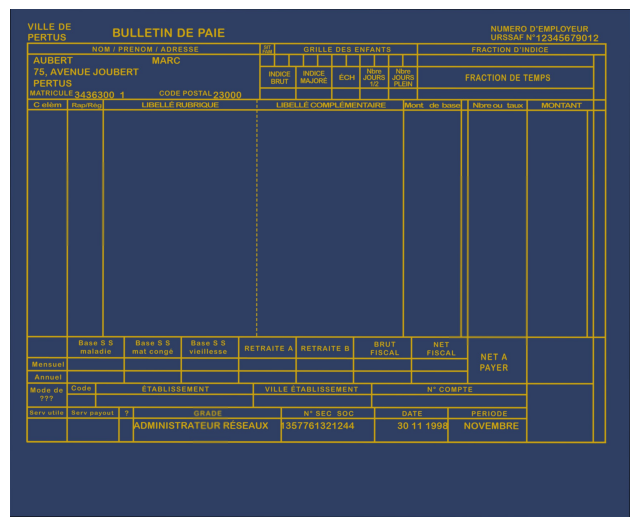

Plotting image with bounding boxes for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A07.jpg


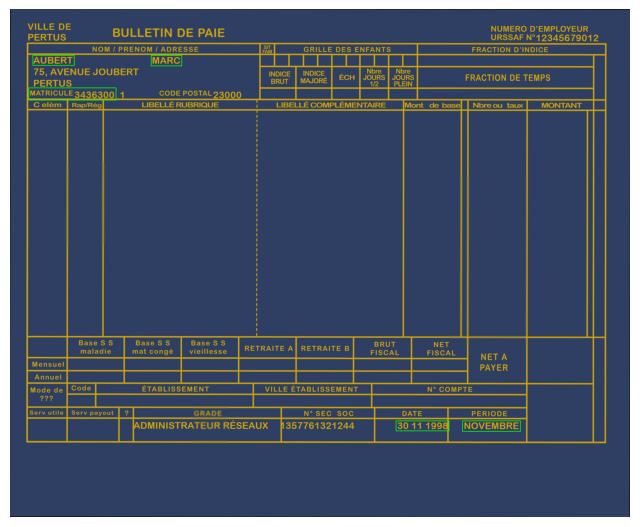

Plotting cropped images for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A07.jpg


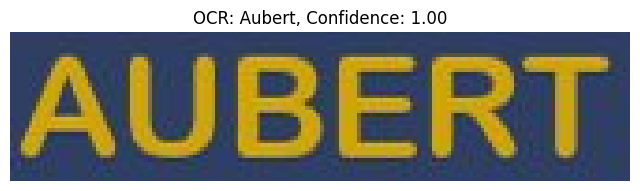

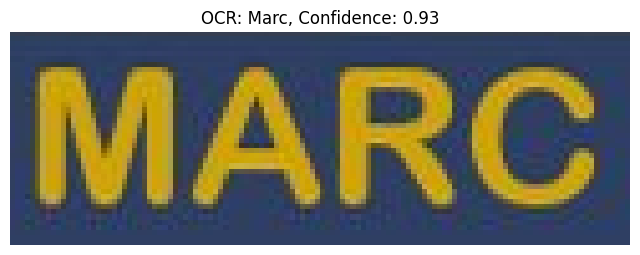

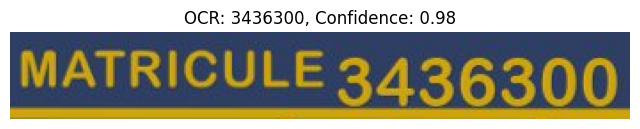

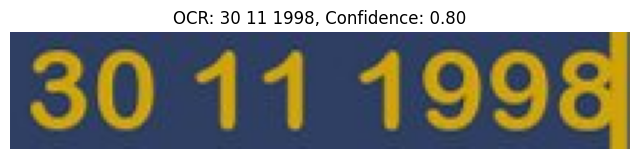

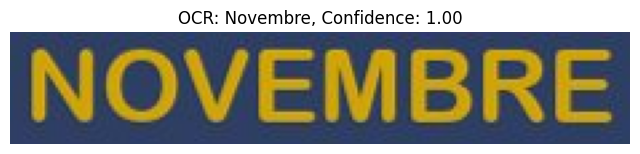

Plotting normal image for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A08.jpg


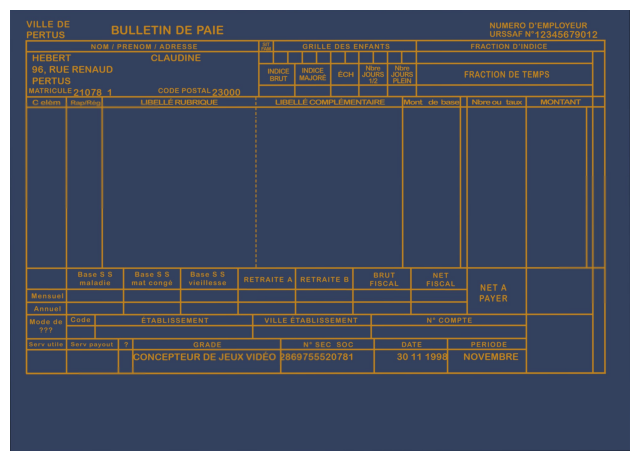

Plotting image with bounding boxes for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A08.jpg


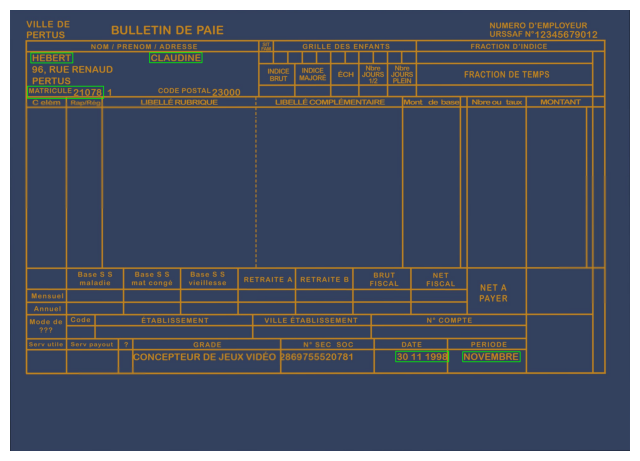

Plotting cropped images for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A08.jpg


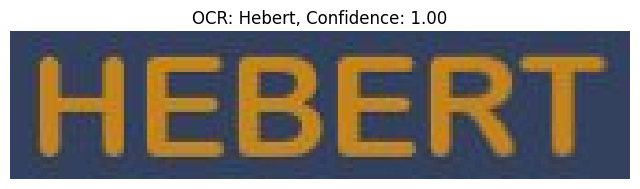

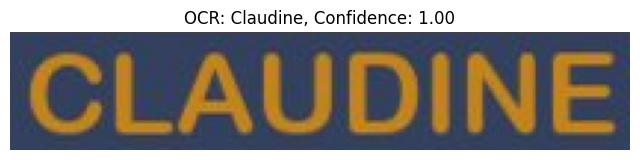

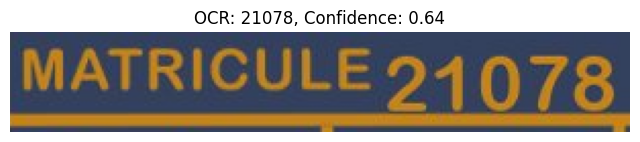

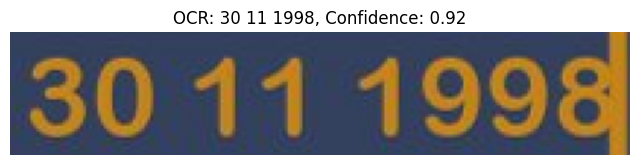

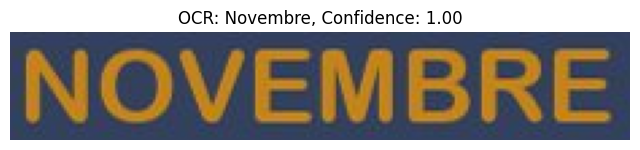

Plotting normal image for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A09.jpg


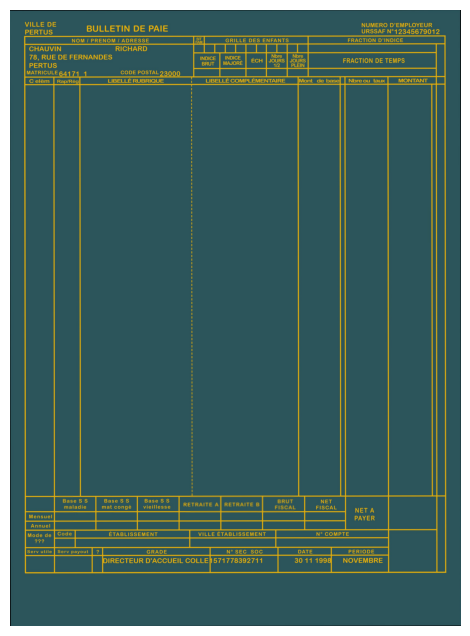

Plotting image with bounding boxes for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A09.jpg


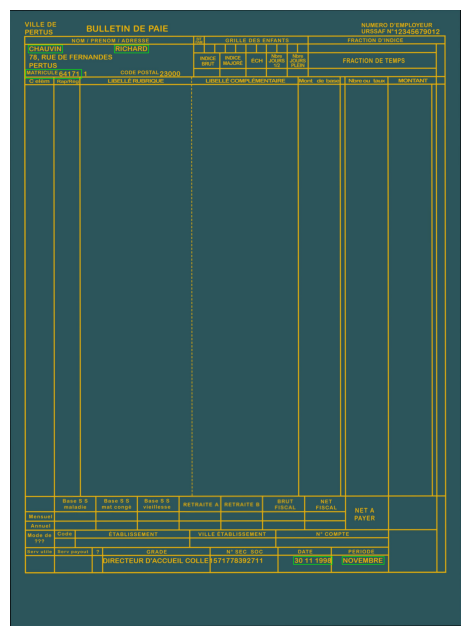

Plotting cropped images for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A09.jpg


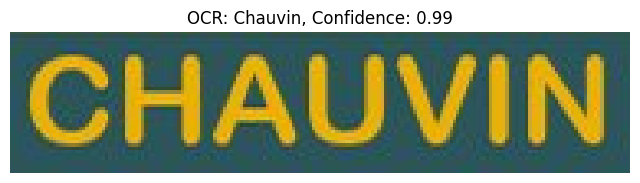

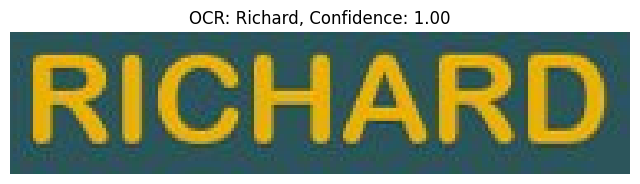

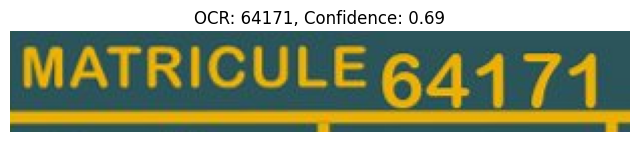

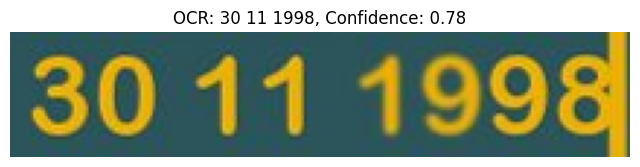

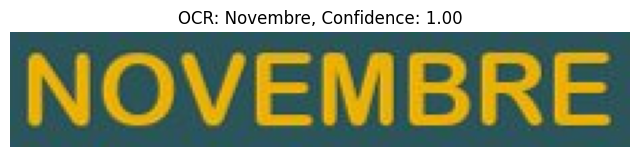

Plotting normal image for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A10.jpg


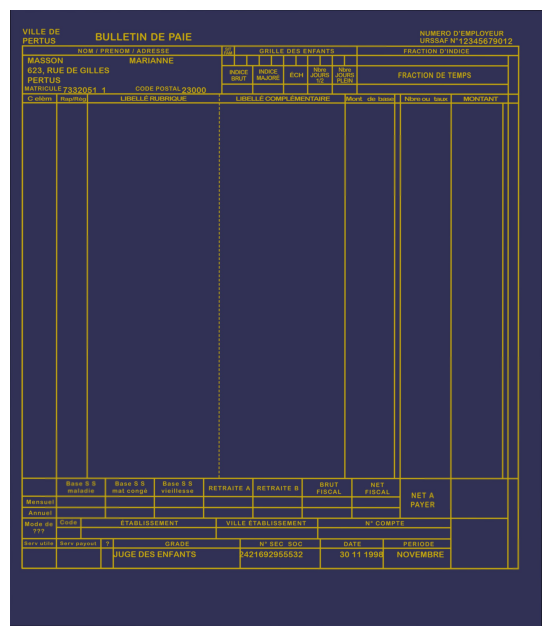

Plotting image with bounding boxes for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A10.jpg


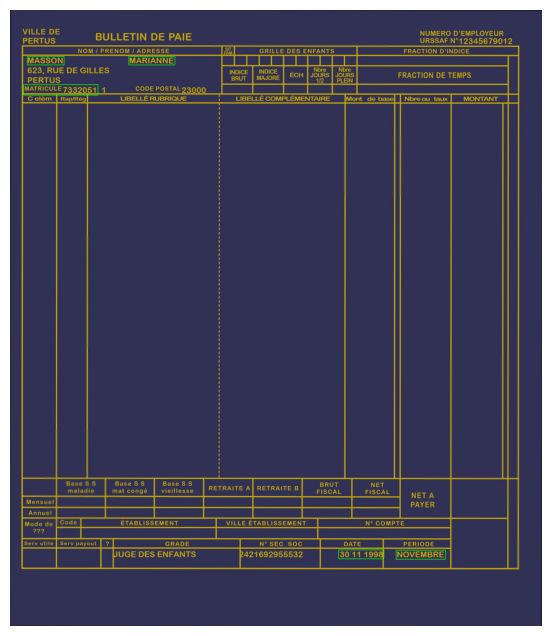

Plotting cropped images for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A10.jpg


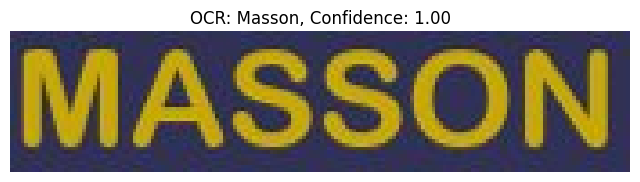

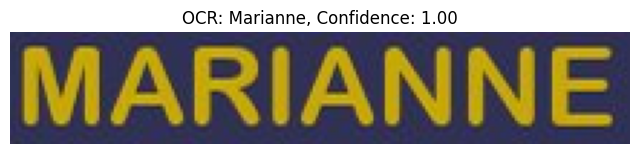

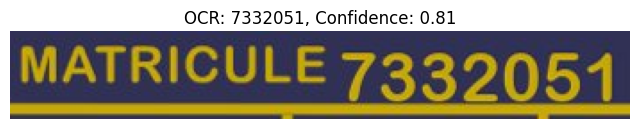

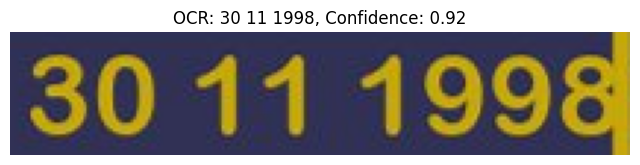

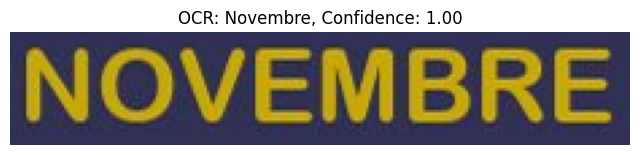

Plotting normal image for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A15.jpg


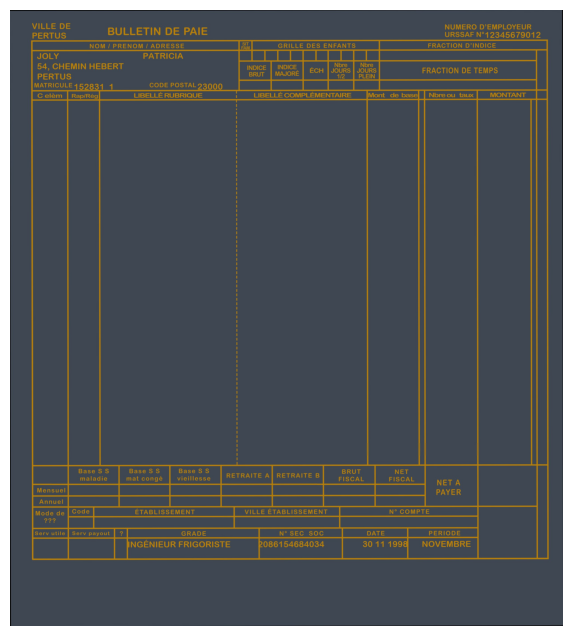

Plotting image with bounding boxes for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A15.jpg


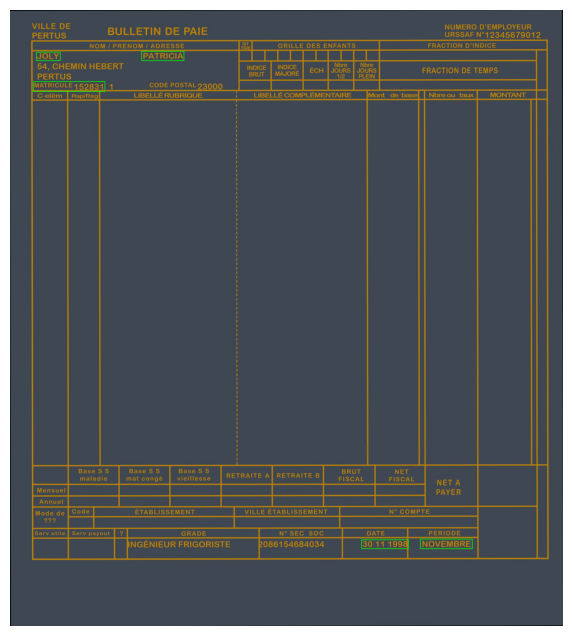

Plotting cropped images for /home/kanna/Django/dev/EasyOCR/sample_image/1998_11_1_A15.jpg


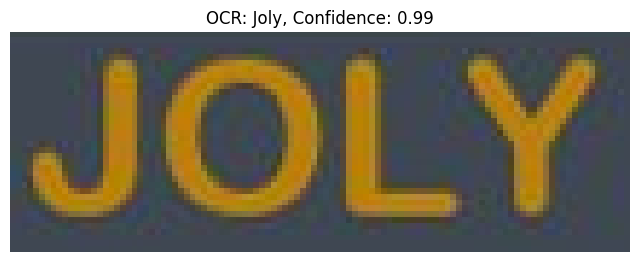

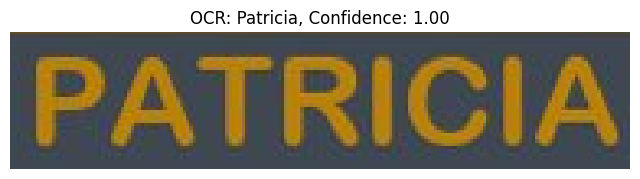

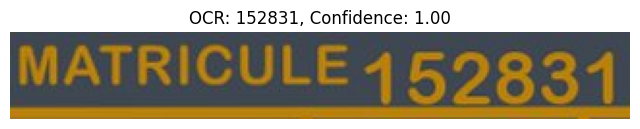

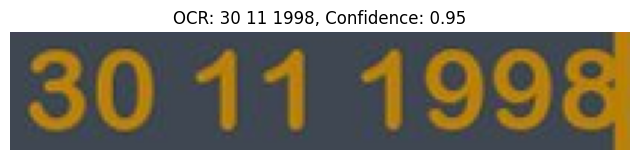

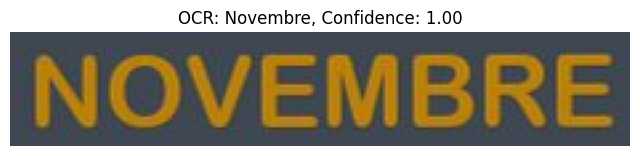

In [5]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Function to plot the image
def plot_image(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Function to plot image with bounding boxes
def plot_image_with_bounding_box(image_path, bounding_boxes):
    img = cv2.imread(image_path)
    
    for box in bounding_boxes:
        pts = np.array(box, np.int32)
        pts = pts.reshape((-1, 1, 2))
        img = cv2.polylines(img, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Convert from BGR (OpenCV) to RGB (Matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Function to plot cropped image with OCR value and confidence
def plot_cropped_image(image_path, bounding_box, ocr_value, confidence):
    img = cv2.imread(image_path)
    
    # Convert bounding box to integer coordinates
    x_min, y_min = map(int, bounding_box[0])
    x_max, y_max = map(int, bounding_box[2])
    
    # Crop the image
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # Convert from BGR (OpenCV) to RGB (Matplotlib)
    cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    
    # Plot cropped image with OCR value and confidence
    plt.figure(figsize=(8, 8))
    plt.imshow(cropped_img_rgb)
    plt.title(f"OCR: {ocr_value}, Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

# Function to read CSV data and plot the images
def plot_images_from_csv(csv_file):
    # Load CSV
    df = pd.read_csv(csv_file)
    
    for index, row in df.iterrows():
        image_path = row['image_name']
        
        # Convert string bounding boxes to list of lists
        first_name_box = eval(row['first_name_boundingbox'])
        last_name_box = eval(row['last_name_bounding_box'])
        matricule_box = eval(row['matricule_boundingbox'])
        date_box = eval(row['date_boundingbox'])
        month_box = eval(row['month_boundingbox'])
        
        # Plot normal image
        print(f"Plotting normal image for {image_path}")
        plot_image(image_path)
        
        # Plot image with bounding boxes
        print(f"Plotting image with bounding boxes for {image_path}")
        plot_image_with_bounding_box(image_path, 
                                     [first_name_box, last_name_box, matricule_box, date_box, month_box])
        
        # Plot cropped images with OCR value and confidence
        print(f"Plotting cropped images for {image_path}")
        plot_cropped_image(image_path, first_name_box, row['first_name_ocr_value'], row['first_name_confidence'])
        plot_cropped_image(image_path, last_name_box, row['last_name_ocr_value'], row['last_name_confidence'])
        plot_cropped_image(image_path, matricule_box, row['matricule_ocr_value'], row['matricule_confidence'])
        plot_cropped_image(image_path, date_box, row['date_ocr_value'], row['date_confidence'])
        plot_cropped_image(image_path, month_box, row['month_ocr_value'], row['month_confidence'])

# Example usage
csv_file = '/home/kanna/Django/dev/EasyOCR/ocr_extracted_data.csv'
plot_images_from_csv(csv_file)
